In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
!unzip atMost800.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: atMost800/train/Species3/00458.jpg  
  inflating: atMost800/train/Species3/00459.jpg  
  inflating: atMost800/train/Species3/00460.jpg  
  inflating: atMost800/train/Species3/00461.jpg  
  inflating: atMost800/train/Species3/00462.jpg  
  inflating: atMost800/train/Species3/00463.jpg  
  inflating: atMost800/train/Species3/00465.jpg  
  inflating: atMost800/train/Species3/00466.jpg  
  inflating: atMost800/train/Species3/00467.jpg  
  inflating: atMost800/train/Species3/00469.jpg  
  inflating: atMost800/train/Species3/00470.jpg  
  inflating: atMost800/train/Species3/00472.jpg  
  inflating: atMost800/train/Species3/00473.jpg  
  inflating: atMost800/train/Species3/00474.jpg  
  inflating: atMost800/train/Species3/00475.jpg  
  inflating: atMost800/train/Species3/00476.jpg  
  inflating: atMost800/train/Species3/00477.jpg  
  inflating: atMost800/train/Species3/00478.jpg  
  inflating: atMost800/train/Species3/00479.jpg  


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Dataset folders 
dataset_dir = 'atMost800'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

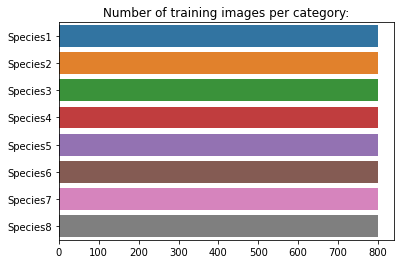

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [11]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 6400 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [12]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0.]
Label: 2
Class name: Species3


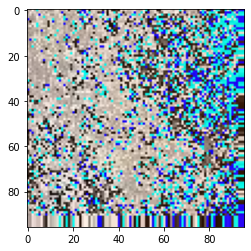

In [13]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

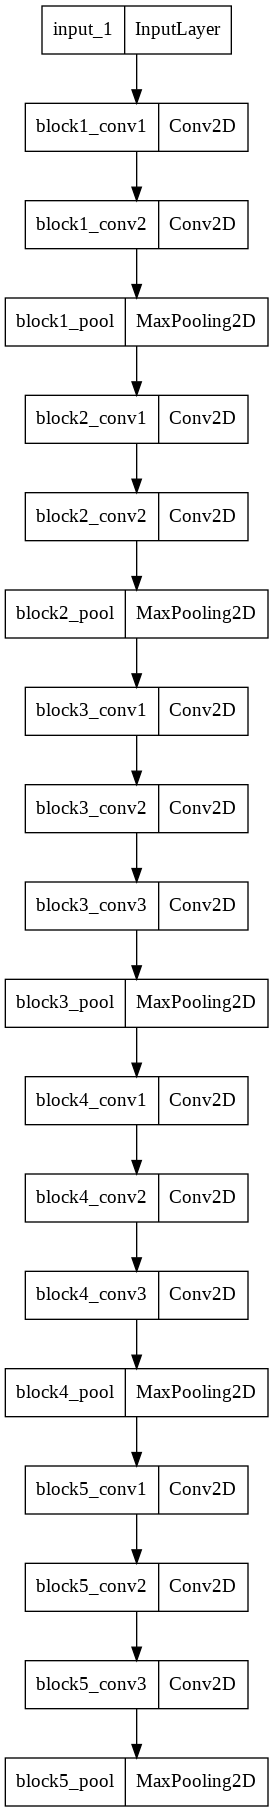

In [15]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [16]:
input_shape = (96, 96, 3)
epochs = 200

In [17]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [18]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [19]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
200/200 [==============================] - ETA: 0s - loss: 2.7805 - accuracy: 0.4166 - precision: 0.4778 - recall: 0.3072

200/200 [==============================] - 44s 177ms/step - loss: 2.7805 - accuracy: 0.4166 - precision: 0.4778 - recall: 0.3072 - val_loss: 1.3026 - val_accuracy: 0.4972 - val_precision: 0.7500 - val_recall: 0.2960
Epoch 2/200
200/200 [==============================] - ETA: 0s - loss: 1.3331 - accuracy: 0.5230 - precision: 0.6474 - recall: 0.3772

200/200 [==============================] - 34s 168ms/step - loss: 1.3331 - accuracy: 0.5230 - precision: 0.6474 - recall: 0.3772 - val_loss: 1.2002 - val_accuracy: 0.5408 - val_precision: 0.6938 - val_recall: 0.3397
Epoch 3/200
200/200 [==============================] - ETA: 0s - loss: 1.2018 - accuracy: 0.5747 - precision: 0.6973 - recall: 0.4369

200/200 [==============================] - 35s 174ms/step - loss: 1.2018 - accuracy: 0.5747 - precision: 0.6973 - recall: 0.4369 - val_loss: 1.0645 - val_accuracy: 0.5958 - val_precision: 0.7759 - val_recall: 0.4269
Epoch 4/200
200/200 [==============================] - ETA: 0s - loss: 1.1113 - accuracy: 0.5989 - precision: 0.7179 - recall: 0.4703

200/200 [==============================] - 35s 174ms/step - loss: 1.1113 - accuracy: 0.5989 - precision: 0.7179 - recall: 0.4703 - val_loss: 1.0406 - val_accuracy: 0.5939 - val_precision: 0.7557 - val_recall: 0.4402
Epoch 5/200
200/200 [==============================] - ETA: 0s - loss: 1.0236 - accuracy: 0.6303 - precision: 0.7444 - recall: 0.5116

200/200 [==============================] - 34s 170ms/step - loss: 1.0236 - accuracy: 0.6303 - precision: 0.7444 - recall: 0.5116 - val_loss: 1.0341 - val_accuracy: 0.6091 - val_precision: 0.7724 - val_recall: 0.4573
Epoch 6/200
200/200 [==============================] - ETA: 0s - loss: 0.9758 - accuracy: 0.6489 - precision: 0.7557 - recall: 0.5325

200/200 [==============================] - 34s 170ms/step - loss: 0.9758 - accuracy: 0.6489 - precision: 0.7557 - recall: 0.5325 - val_loss: 0.9900 - val_accuracy: 0.6528 - val_precision: 0.7599 - val_recall: 0.4744
Epoch 7/200
200/200 [==============================] - ETA: 0s - loss: 0.9352 - accuracy: 0.6650 - precision: 0.7720 - recall: 0.5570

200/200 [==============================] - 36s 178ms/step - loss: 0.9352 - accuracy: 0.6650 - precision: 0.7720 - recall: 0.5570 - val_loss: 0.9750 - val_accuracy: 0.6262 - val_precision: 0.7528 - val_recall: 0.5142
Epoch 8/200
200/200 [==============================] - ETA: 0s - loss: 0.9025 - accuracy: 0.6775 - precision: 0.7810 - recall: 0.5805

200/200 [==============================] - 35s 175ms/step - loss: 0.9025 - accuracy: 0.6775 - precision: 0.7810 - recall: 0.5805 - val_loss: 0.9753 - val_accuracy: 0.6509 - val_precision: 0.7429 - val_recall: 0.4991
Epoch 9/200
200/200 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.6895 - precision: 0.7801 - recall: 0.5898

200/200 [==============================] - 34s 171ms/step - loss: 0.8645 - accuracy: 0.6895 - precision: 0.7801 - recall: 0.5898 - val_loss: 0.9672 - val_accuracy: 0.6376 - val_precision: 0.7741 - val_recall: 0.5332
Epoch 10/200
200/200 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.6938 - precision: 0.7869 - recall: 0.6064

200/200 [==============================] - 35s 174ms/step - loss: 0.8554 - accuracy: 0.6938 - precision: 0.7869 - recall: 0.6064 - val_loss: 0.9213 - val_accuracy: 0.6452 - val_precision: 0.7526 - val_recall: 0.5427
Epoch 11/200
200/200 [==============================] - ETA: 0s - loss: 0.8293 - accuracy: 0.6988 - precision: 0.7928 - recall: 0.6061

200/200 [==============================] - 37s 183ms/step - loss: 0.8293 - accuracy: 0.6988 - precision: 0.7928 - recall: 0.6061 - val_loss: 0.9667 - val_accuracy: 0.6509 - val_precision: 0.7525 - val_recall: 0.5655
Epoch 12/200
200/200 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.7163 - precision: 0.8024 - recall: 0.6356

200/200 [==============================] - 34s 171ms/step - loss: 0.7785 - accuracy: 0.7163 - precision: 0.8024 - recall: 0.6356 - val_loss: 0.9230 - val_accuracy: 0.6490 - val_precision: 0.7579 - val_recall: 0.5465
Epoch 13/200
200/200 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.7106 - precision: 0.7974 - recall: 0.6273

200/200 [==============================] - 35s 176ms/step - loss: 0.8024 - accuracy: 0.7106 - precision: 0.7974 - recall: 0.6273 - val_loss: 0.9468 - val_accuracy: 0.6641 - val_precision: 0.7429 - val_recall: 0.5427
Epoch 14/200
200/200 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.7206 - precision: 0.8018 - recall: 0.6414

200/200 [==============================] - 41s 206ms/step - loss: 0.7755 - accuracy: 0.7206 - precision: 0.8018 - recall: 0.6414 - val_loss: 0.9232 - val_accuracy: 0.6698 - val_precision: 0.7487 - val_recall: 0.5541
Epoch 15/200
200/200 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.7244 - precision: 0.8133 - recall: 0.6377

200/200 [==============================] - 34s 172ms/step - loss: 0.7907 - accuracy: 0.7244 - precision: 0.8133 - recall: 0.6377 - val_loss: 0.9717 - val_accuracy: 0.6471 - val_precision: 0.7467 - val_recall: 0.5313
Epoch 16/200
200/200 [==============================] - ETA: 0s - loss: 0.7575 - accuracy: 0.7377 - precision: 0.8167 - recall: 0.6647

200/200 [==============================] - 36s 181ms/step - loss: 0.7575 - accuracy: 0.7377 - precision: 0.8167 - recall: 0.6647 - val_loss: 0.9597 - val_accuracy: 0.6376 - val_precision: 0.7345 - val_recall: 0.5408
Epoch 17/200
200/200 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7437 - precision: 0.8220 - recall: 0.6637

200/200 [==============================] - 35s 175ms/step - loss: 0.7367 - accuracy: 0.7437 - precision: 0.8220 - recall: 0.6637 - val_loss: 0.9600 - val_accuracy: 0.6376 - val_precision: 0.7580 - val_recall: 0.5408
Epoch 18/200
200/200 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.7330 - precision: 0.8164 - recall: 0.6531

200/200 [==============================] - 34s 169ms/step - loss: 0.7482 - accuracy: 0.7330 - precision: 0.8164 - recall: 0.6531 - val_loss: 0.9459 - val_accuracy: 0.6584 - val_precision: 0.7532 - val_recall: 0.5560
Epoch 19/200
200/200 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7464 - precision: 0.8231 - recall: 0.6748

200/200 [==============================] - 34s 169ms/step - loss: 0.7110 - accuracy: 0.7464 - precision: 0.8231 - recall: 0.6748 - val_loss: 0.9820 - val_accuracy: 0.6546 - val_precision: 0.7288 - val_recall: 0.5712
Epoch 20/200
200/200 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7555 - precision: 0.8255 - recall: 0.6877

200/200 [==============================] - 34s 169ms/step - loss: 0.7010 - accuracy: 0.7555 - precision: 0.8255 - recall: 0.6877 - val_loss: 0.9232 - val_accuracy: 0.6812 - val_precision: 0.7584 - val_recall: 0.5598
Epoch 21/200
200/200 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7431 - precision: 0.8208 - recall: 0.6744

200/200 [==============================] - 35s 176ms/step - loss: 0.7319 - accuracy: 0.7431 - precision: 0.8208 - recall: 0.6744 - val_loss: 0.9361 - val_accuracy: 0.6926 - val_precision: 0.7719 - val_recall: 0.5844
Epoch 22/200
200/200 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.7570 - precision: 0.8283 - recall: 0.6927

200/200 [==============================] - 34s 172ms/step - loss: 0.6859 - accuracy: 0.7570 - precision: 0.8283 - recall: 0.6927 - val_loss: 0.9509 - val_accuracy: 0.6565 - val_precision: 0.7494 - val_recall: 0.5901
Epoch 23/200
200/200 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7475 - precision: 0.8199 - recall: 0.6762

200/200 [==============================] - 34s 172ms/step - loss: 0.7117 - accuracy: 0.7475 - precision: 0.8199 - recall: 0.6762 - val_loss: 0.9284 - val_accuracy: 0.6622 - val_precision: 0.7647 - val_recall: 0.5674
Epoch 24/200
200/200 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7572 - precision: 0.8319 - recall: 0.6881

200/200 [==============================] - 37s 187ms/step - loss: 0.6703 - accuracy: 0.7572 - precision: 0.8319 - recall: 0.6881 - val_loss: 0.9901 - val_accuracy: 0.6414 - val_precision: 0.7311 - val_recall: 0.5674
Epoch 25/200
200/200 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7678 - precision: 0.8340 - recall: 0.7042

200/200 [==============================] - 35s 174ms/step - loss: 0.6501 - accuracy: 0.7678 - precision: 0.8340 - recall: 0.7042 - val_loss: 0.9744 - val_accuracy: 0.6509 - val_precision: 0.7340 - val_recall: 0.5655
Epoch 26/200
200/200 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.7720 - precision: 0.8423 - recall: 0.7077

200/200 [==============================] - 34s 171ms/step - loss: 0.6630 - accuracy: 0.7720 - precision: 0.8423 - recall: 0.7077 - val_loss: 0.9269 - val_accuracy: 0.6641 - val_precision: 0.7632 - val_recall: 0.5750
Epoch 27/200
200/200 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7681 - precision: 0.8341 - recall: 0.7077

200/200 [==============================] - 34s 171ms/step - loss: 0.6651 - accuracy: 0.7681 - precision: 0.8341 - recall: 0.7077 - val_loss: 0.9349 - val_accuracy: 0.6660 - val_precision: 0.7488 - val_recall: 0.5769
Epoch 28/200
200/200 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7763 - precision: 0.8408 - recall: 0.7056

200/200 [==============================] - 35s 173ms/step - loss: 0.6460 - accuracy: 0.7763 - precision: 0.8408 - recall: 0.7056 - val_loss: 0.9110 - val_accuracy: 0.6793 - val_precision: 0.7603 - val_recall: 0.5958
Epoch 29/200
200/200 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7747 - precision: 0.8398 - recall: 0.7173

200/200 [==============================] - 35s 173ms/step - loss: 0.6511 - accuracy: 0.7747 - precision: 0.8398 - recall: 0.7173 - val_loss: 0.9620 - val_accuracy: 0.6603 - val_precision: 0.7636 - val_recall: 0.5332
Epoch 30/200
200/200 [==============================] - ETA: 0s - loss: 0.6330 - accuracy: 0.7808 - precision: 0.8492 - recall: 0.7138

200/200 [==============================] - 33s 166ms/step - loss: 0.6330 - accuracy: 0.7808 - precision: 0.8492 - recall: 0.7138 - val_loss: 0.9848 - val_accuracy: 0.6546 - val_precision: 0.7476 - val_recall: 0.5844
Epoch 31/200
200/200 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7702 - precision: 0.8339 - recall: 0.7083

200/200 [==============================] - 34s 171ms/step - loss: 0.6570 - accuracy: 0.7702 - precision: 0.8339 - recall: 0.7083 - val_loss: 0.9213 - val_accuracy: 0.6679 - val_precision: 0.7545 - val_recall: 0.5541


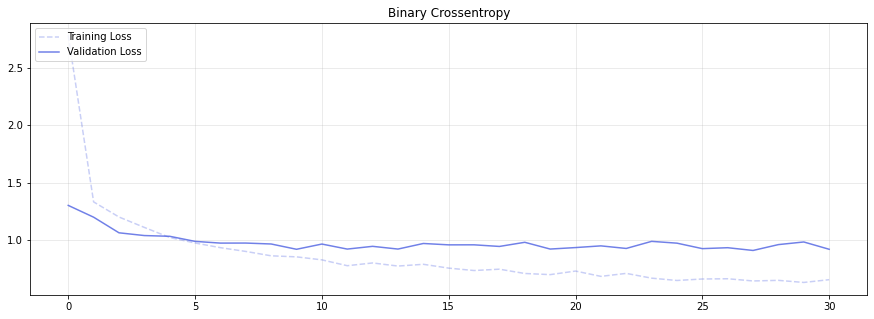

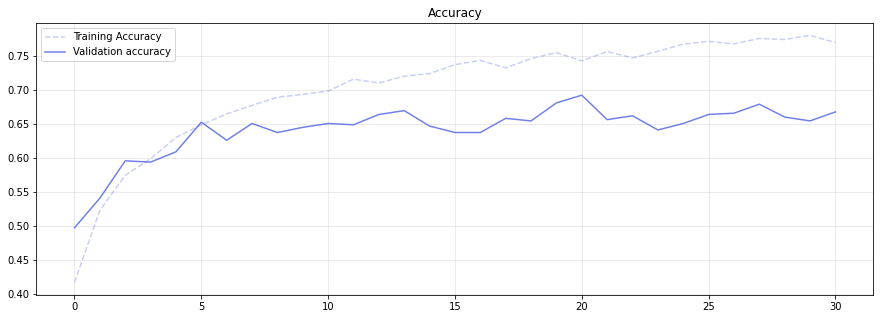

In [20]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [22]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [23]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [24]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [25]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [26]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
200/200 [==============================] - 33s 153ms/step - loss: 0.9813 - accuracy: 0.6617 - precision_1: 0.7494 - recall_1: 0.5761 - val_loss: 0.9912 - val_accuracy: 0.6603 - val_precision_1: 0.7444 - val_recall_1: 0.5636
Epoch 2/200
200/200 [==============================] - 29s 144ms/step - loss: 0.7570 - accuracy: 0.7427 - precision_1: 0.8206 - recall_1: 0.6641 - val_loss: 0.9017 - val_accuracy: 0.6414 - val_precision_1: 0.7500 - val_recall_1: 0.5579
Epoch 3/200
200/200 [==============================] - 29s 147ms/step - loss: 0.6349 - accuracy: 0.7825 - precision_1: 0.8461 - recall_1: 0.7208 - val_loss: 0.8404 - val_accuracy: 0.7021 - val_precision_1: 0.7642 - val_recall_1: 0.6395
Epoch 4/200
200/200 [==============================] - 28s 141ms/step - loss: 0.5480 - accuracy: 0.8120 - precision_1: 0.8633 - recall_1: 0.7577 - val_loss: 0.7816 - val_accuracy: 0.7476 - val_precision_1: 0.8066 - val_recall_1: 0.6964
Epoch 5/200
200/200 [==============================] - 2

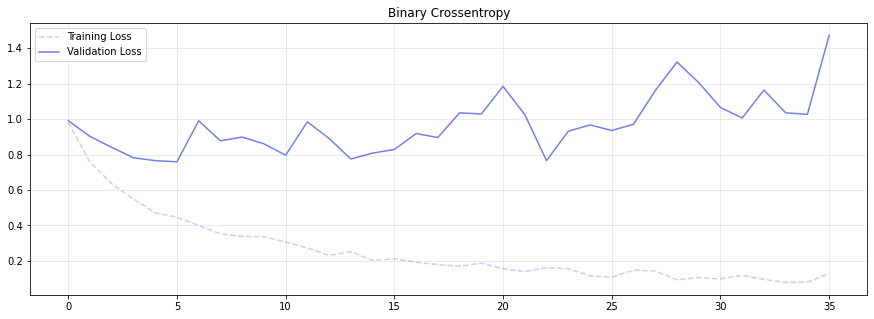

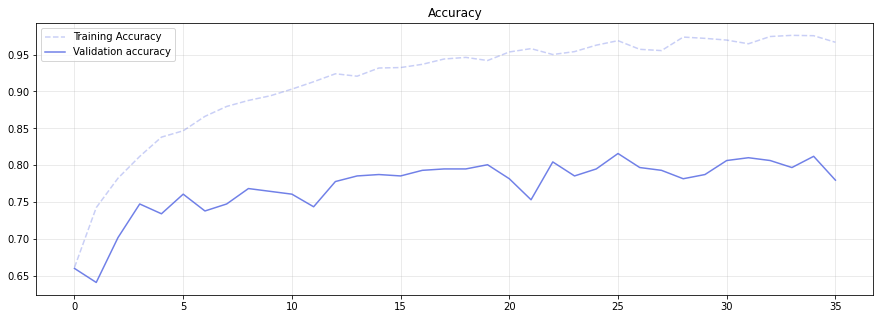

In [27]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [28]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [29]:
tl_model.save('Vgg16/Tuned_v1_1')

In [30]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 2s 97ms/step - loss: 1.0630 - accuracy: 0.7950 - precision_1: 0.8006 - recall_1: 0.7784

Test metrics
{'loss': 1.0630459785461426, 'accuracy': 0.7950138449668884, 'precision_1': 0.8005697727203369, 'recall_1': 0.7783933281898499}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.795
Precision: 0.7909
Recall: 0.7751
F1: 0.7805


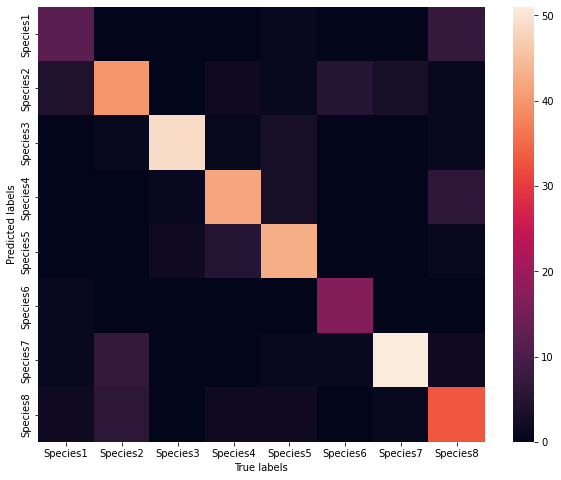

In [31]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()